# SWB Computational Models

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import scipy.stats as stats
import pandas as pd
import scipy
from scipy.optimize import least_squares
import sklearn
from sklearn.metrics import r2_score
import random
import os
from statannot import add_stat_annotation
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
import datetime




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
base_dir  = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
behav_dir = f'{base_dir}behavior_analysis/'


In [4]:
import sys
sys.path.append(f'{base_dir}swb_computational_modeling/swb_behav_models/scripts')
from SWB_modeling_utils import *

In [5]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

06152024


In [6]:
# load subj_ids of subj with preprocessed ephys data
subj_ids = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID.tolist()
# find subj without sufficient variation in mood ratings and drop from subj_ids list 
subj_ids = [subj_ids[idx] for idx in np.arange(0,len(subj_ids))[pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[2]).mood_var.isnull()]]
subj_ids


['MS002',
 'MS003',
 'MS009',
 'MS011',
 'MS015',
 'MS017',
 'MS019',
 'MS022',
 'MS024',
 'MS025',
 'MS026',
 'MS027',
 'MS029',
 'MS033',
 'MS035',
 'MS041',
 'MS043',
 'MS048',
 'DA8',
 'DA023',
 'DA037']

In [7]:
#get swb bdi and bai 
raw_dir = f'{base_dir}behavior_analysis/behavior_raw/'
subj_bdi = []
subj_bai = []
for subj_id in subj_ids:
    raw_data_dir = f'{raw_dir}{subj_id}/'
    raw_data_files = os.listdir(raw_data_dir)
    #load task data
    #load swb bdi and bai info to add to mood df
    raw_bdi_name = [x for x in raw_data_files if 'BDI' in x] #not all subj have BDI
    if raw_bdi_name:
        raw_bdi = pd.read_table(raw_data_dir+raw_bdi_name[0]) 
        bdi = raw_bdi['BDI Score'].iloc[-1]   
    else:
        bdi = 0
    subj_bdi.append(bdi)

    #bai loading (not all subj have BAI)
    raw_bai_name = [x for x in raw_data_files if 'BAI' in x]
    if raw_bai_name:
        raw_bai = pd.read_table(raw_data_dir+raw_bai_name[0]) 
        bai = raw_bai['BAI Score'].iloc[-1]   
    else:
        bai = 0
    subj_bai.append(bai)


In [8]:
list(zip(subj_ids,subj_bdi))

[('MS002', 14),
 ('MS003', 8),
 ('MS009', 16),
 ('MS011', 13),
 ('MS015', 26),
 ('MS017', 26),
 ('MS019', 12),
 ('MS022', 10),
 ('MS024', 16),
 ('MS025', 10),
 ('MS026', 9),
 ('MS027', 22),
 ('MS029', 32),
 ('MS033', 39),
 ('MS035', 15),
 ('MS041', 10),
 ('MS043', 23),
 ('MS048', 19),
 ('DA8', 13),
 ('DA023', 14),
 ('DA037', 4)]

In [43]:
all_mood = pd.concat([pd.read_csv(f'{behav_dir}behavior_preprocessed/{subj_id}_rate_data').assign(subj_id = subj_id) for subj_id in subj_ids]).reset_index()

all_mood = all_mood.drop(columns = ['RatingOnset.1','RT','RatingOnset','index','bai'])
all_mood = all_mood[all_mood.Round !=1].reset_index(drop=True)

all_mood

,Round,Rating,zscore_mood,bdi,subj_id
0,4,70.0,0.320722,14,MS002
1,7,70.0,0.320722,14,MS002
2,10,69.0,0.185132,14,MS002
3,13,71.0,0.456312,14,MS002
4,16,71.0,0.456312,14,MS002
...,...,...,...,...,...
1045,139,42.0,-0.403568,4,DA037
1046,142,50.0,0.150828,4,DA037
1047,145,3.0,-3.106249,4,DA037
1048,148,50.0,0.150828,4,DA037


In [41]:
subj_idx_info = []

for subj_id in subj_ids:
    subj_mood = all_mood[all_mood.subj_id == subj_id]
    subj_t1   = subj_mood.Round-1
    subj_t2   = subj_mood.Round-2
    subj_t3   = subj_mood.Round-3
    subj_idx_info.append(pd.DataFrame({'subj_id':[subj_id]*len(subj_t3),
                              't1_round_idx':subj_t1,
                              't2_round_idx':subj_t2,
                              't3_round_idx':subj_t3,
                              'norm_mood':zscore(subj_mood.Rating)}))
subj_idx_info = pd.concat(subj_idx_info).reset_index(drop=True)


In [44]:
subj_mood

,Round,Rating,zscore_mood,bdi,subj_id
1000,4,56.0,0.566625,4,DA037
1001,7,87.0,2.714910,4,DA037
1002,10,50.0,0.150828,4,DA037
1003,13,55.0,0.497326,4,DA037
1004,16,59.0,0.774524,4,DA037
1005,19,57.0,0.635925,4,DA037
1006,22,46.0,-0.126370,4,DA037
1007,25,57.0,0.635925,4,DA037
1008,28,54.0,0.428026,4,DA037
1009,31,46.0,-0.126370,4,DA037


In [45]:
subj_idx_info = []

for subj_id in subj_ids:
    subj_mood = all_mood[all_mood.subj_id == subj_id]
    subj_t1   = subj_mood.Round-1
    subj_t2   = subj_mood.Round-2
    subj_t3   = subj_mood.Round-3
    subj_idx_info.append(pd.DataFrame({'subj_id':subj_mood.subj_id,'Round':subj_mood.Round,
                                       'Rating':subj_mood.Rating,'zscore_mood':subj_mood.zscore_mood,'bdi':subj_mood.bdi,
                                        't1_round_idx':subj_t1,
                                        't2_round_idx':subj_t2,
                                        't3_round_idx':subj_t3,
                                        'norm_mood':zscore(subj_mood.Rating)}))
subj_idx_info = pd.concat(subj_idx_info).reset_index(drop=True)


In [46]:
subj_idx_info

,subj_id,Round,Rating,zscore_mood,bdi,t1_round_idx,t2_round_idx,t3_round_idx,norm_mood
0,MS002,4,70.0,0.320722,14,3,2,1,0.277664
1,MS002,7,70.0,0.320722,14,6,5,4,0.277664
2,MS002,10,69.0,0.185132,14,9,8,7,0.134538
3,MS002,13,71.0,0.456312,14,12,11,10,0.420789
4,MS002,16,71.0,0.456312,14,15,14,13,0.420789
...,...,...,...,...,...,...,...,...,...
1045,DA037,139,42.0,-0.403568,4,138,137,136,-0.400644
1046,DA037,142,50.0,0.150828,4,141,140,139,0.153881
1047,DA037,145,3.0,-3.106249,4,144,143,142,-3.103953
1048,DA037,148,50.0,0.150828,4,147,146,145,0.153881


In [55]:
all_behav = pd.concat([pd.read_csv(f'{behav_dir}/behavior_preprocessed/{subj_id}_task_data').assign(subj_id = subj_id) for subj_id in subj_ids]).reset_index(drop=True)
all_behav['TrialEV'] = all_behav.GambleEV - all_behav.SafeBet
all_behav['GambleChoice'] = pd.factorize(all_behav['GambleChoice'].astype('category'))[0]
all_behav['TrialType'] = pd.factorize(all_behav['TrialType'].astype('category'))[0]
all_behav



,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE,subj_id,TrialEV
0,1,25.0,0,513.380590,513.390239,515.450091,515.457173,2.059852,0.0,-1.10,...,-0.57,-0.57,0.00,0.00,0.57,0.57,0.000,0.000,MS002,-0.265
1,2,117.0,1,522.640856,522.641563,524.596127,526.627092,1.954564,-0.3,-0.95,...,-0.95,-0.65,0.00,0.00,0.00,-0.30,0.000,-0.475,MS002,-0.175
2,3,79.0,2,531.174799,531.175599,532.759061,534.780269,1.583462,0.4,0.00,...,0.00,0.00,1.68,1.28,0.00,0.40,0.840,0.000,MS002,0.440
3,4,42.0,0,545.592613,545.593355,548.084966,548.092333,2.491611,0.0,-0.80,...,0.00,0.00,0.80,0.80,-0.80,-0.80,0.000,0.000,MS002,0.200
4,5,85.0,2,555.337336,555.345720,557.114656,559.135069,1.768936,0.5,0.00,...,0.00,0.00,1.24,0.74,0.00,0.50,0.620,0.000,MS002,0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147,146,32.0,0,2209.402302,2209.435636,2211.064931,2213.082789,1.629295,0.0,-1.50,...,0.00,0.00,2.49,0.99,-1.50,0.00,1.245,0.000,DA037,-0.255
3148,147,25.0,0,2217.997983,2218.017422,2225.058874,2225.067856,7.041451,0.0,-1.10,...,-0.57,-0.57,0.00,0.00,0.57,0.57,0.000,0.000,DA037,-0.265
3149,148,39.0,0,2235.071490,2235.086871,2237.386308,2239.403627,2.299437,0.0,-0.50,...,0.00,0.00,1.25,0.75,-0.50,0.00,0.625,0.000,DA037,0.125
3150,149,94.0,2,2244.619878,2244.621079,2247.048609,2249.067155,2.427530,0.6,0.00,...,-1.33,-0.60,0.00,0.00,1.33,0.60,0.000,-0.665,DA037,0.065


In [ ]:
# continuous_regressors = ['TrialEV','GambleEV','GambleEV_t1','SafeBet','Profit','TotalProfit','CR', 'choiceEV', 'RPE',
#                          'decisionCPE', 'decisionRegret','decisionRelief']

# def norm_zscore(reg_array):
#     return (reg_array-np.mean(reg_array))/(2*np.std(reg_array))
# cols_to_nan = ['GambleChoice', 'Outcome','TrialEV',
#        'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
#        'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
#        'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
#        'nRPE']

# cols_to_zscore = cols_to_nan.copy()
# cols_to_zscore.remove('GambleChoice')
# cols_to_zscore.remove('Outcome')


In [52]:
# # Load all subj behav data 
# all_behav = pd.concat([pd.read_csv(f'{behav_dir}behavior_preprocessed/{subj_id}_task_data').assign(subj_id = subj_id) for subj_id in subj_ids]).reset_index(drop=True)
# all_behav['TrialEV'] = all_behav.GambleEV - all_behav.SafeBet
# all_behav['GambleChoice'] = pd.factorize(all_behav['GambleChoice'].astype('category'))[0]
# # NaN all data for regressor variables for no response trials
# all_behav[cols_to_nan].iloc[(all_behav.GambleChoice!='gamble') & (all_behav.GambleChoice != 'safe')] = np.nan
# # all_behav = all_behav[(all_behav.GambleChoice=='gamble') | (all_behav.GambleChoice == 'safe')].reset_index(drop=True)

# # NaN all data for regressor variables for no outcome trials 
# all_behav[cols_to_nan].iloc[(all_behav.Outcome!='good') & (all_behav.Outcome != 'bad')] = np.nan
# # all_behav = all_behav[(all_behav.Outcome=='good') | (all_behav.Outcome == 'bad')].reset_index(drop=True)
# # all_behav.Round = all_behav.Round.astype('Int64') # Round converts to float when nans are introduced to df 


# # = pd.DataFrame({f'{col}':zscore(all_behav[col]) for col in cols_to_zscore})
# all_behav[cols_to_zscore] = pd.DataFrame({f'{col}':zscore(all_behav[col]) for col in cols_to_zscore})
# # # all_behav[cols_to_zscore] = pd.DataFrame({f'{col}':zscore(all_behav[col]) for col in cols_to_zscore})

# all_behav


# Format Data Frame for GLM inputs 

# Test Mood Models

In [168]:
main_var = 'decisionCPE'
iter_vars = ['TrialEV','TotalProfit','choiceEV']

var_combos = [[v,main_var] for v in iter_vars]

for i in range(1,len(iter_vars)-1):
    iter_list = [list(tup)+[main_var] for tup in list(itertools.combinations(iter_vars,i+1))]
    var_combos.extend(iter_list)


var_combos = [combo for combo in var_combos if ('choiceEV' in combo and 'TrialEV' not in combo)|
              ('choiceEV' not in combo and 'TrialEV' in combo)|('choiceEV'not in combo and 'TrialEV' not in combo)]


# var_combos = [combo for combo in var_combos if ('GambleEV' in combo and 'TrialEV' not in combo)|
#               ('GambleEV' not in combo and 'TrialEV' in combo)|('GambleEV'not in combo and 'TrialEV' not in combo)]

var_combos

[['TrialEV', 'decisionCPE'],
 ['TotalProfit', 'decisionCPE'],
 ['choiceEV', 'decisionCPE'],
 ['TrialEV', 'TotalProfit', 'decisionCPE'],
 ['TotalProfit', 'choiceEV', 'decisionCPE']]

In [169]:
model_inputs = {f'{("_").join(vars)}':{} for vars in var_combos}


In [170]:
model_inputs = {f'{("_").join(vars)}':{} for vars in var_combos}

for model_vars in var_combos:
    # var_key = ("_").join(model_vars)
    input_df = []
    for subj_id in subj_ids: 
        subj_dict = {}
        subj_mood_data = subj_idx_info[subj_idx_info.subj_id == subj_id].reset_index(drop=True)
        subj_norm_mood = subj_mood_data.norm_mood.tolist()
        subj_dict['mood'] = subj_norm_mood
        subj_dict['bdi'] = subj_mood_data.bdi.tolist()
        subj_behav_data = all_behav[all_behav.subj_id == subj_id].reset_index(drop=True)
        for reg in model_vars:
            # make reg name strings for model data keys
            reg_t1 = reg + '_t1'
            reg_t2 = reg + '_t2'
            reg_t3 = reg + '_t3'
            subj_dict[reg_t1] = [subj_behav_data[reg].iloc[np.where(subj_behav_data.Round==round_num)[0][0]] for round_num in subj_mood_data.t1_round_idx]
            subj_dict[reg_t2] = [subj_behav_data[reg].iloc[np.where(subj_behav_data.Round==round_num)[0][0]] for round_num in subj_mood_data.t2_round_idx]
            subj_dict[reg_t3] = [subj_behav_data[reg].iloc[np.where(subj_behav_data.Round==round_num)[0][0]] for round_num in subj_mood_data.t3_round_idx]
            
        subj_dict = pd.DataFrame(subj_dict).assign(subj_id = subj_id)
        input_df.append(subj_dict)
    
    model_inputs[("_").join(model_vars)] = pd.concat(input_df).reset_index(drop=True)


In [172]:
model_inputs.keys()

dict_keys(['TrialEV_decisionCPE', 'TotalProfit_decisionCPE', 'choiceEV_decisionCPE', 'TrialEV_TotalProfit_decisionCPE', 'TotalProfit_choiceEV_decisionCPE'])

In [173]:
model_results = {f'{model}':{f'{subj_id}':{} for subj_id in subj_ids} for model in model_inputs.keys()}
gamma_bounds = [(0.0001,1)]
n_inits = 2

for model in model_inputs.keys():
    model_data   = model_inputs[model]
    reg_list     = model.split('_')
    param_bounds = gamma_bounds + [(-10,10) for reg_num in range(len(reg_list)+1)]
    gam_inits    = np.array([np.random.uniform(0,1) for n in range(n_inits)])
    var_inits    = [np.random.uniform(-1,1,n_inits) for n in range(len(reg_list)+1)]

    for subj_id in subj_ids:
        subj_data      = model_inputs[model][model_inputs[model].subj_id == subj_id]
        var_init_grid  = itertools.product(*np.vstack((gam_inits,var_inits)))
        subj_model_fit = parallel_glm_fit(min_negll_glm,fit_swb_glm,var_init_grid,param_bounds,subj_data,reg_list)
        model_results[model][subj_id] = subj_model_fit





[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    5.2s remaining:    6.7s
[Parallel(n_jobs=-2)]: Done  11 out of  16 | elapsed:    5.5s remaining:    2.5s
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed:    5.7s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done  11 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  11 out of  16 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    0.2s remaining: 

In [115]:
model_results.keys()

dict_keys(['GambleEV_decisionCPE', 'TrialEV_decisionCPE', 'TotalProfit_decisionCPE', 'GambleChoice_decisionCPE', 'GambleEV_TotalProfit_decisionCPE', 'GambleEV_GambleChoice_decisionCPE', 'TrialEV_TotalProfit_decisionCPE', 'TrialEV_GambleChoice_decisionCPE', 'TotalProfit_GambleChoice_decisionCPE', 'GambleEV_TotalProfit_GambleChoice_decisionCPE', 'TrialEV_TotalProfit_GambleChoice_decisionCPE'])

In [116]:
subj_model_fit

{'best_result':   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 58.488479442497216
         x: [ 5.864e-01 -4.864e-01  2.985e-01  5.232e-02  3.535e-01
              2.519e-01]
       nit: 44
       jac: [-5.684e-06  4.263e-06  1.421e-06 -3.055e-05  6.395e-06
              7.105e-07]
      nfev: 490
      njev: 70
  hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>,
 'subj_dict': {'params': array([ 0.58637525, -0.48641464,  0.298512  ,  0.05231872,  0.35350421,
          0.25187775]),
  'reg_list': ['TrialEV', 'TotalProfit', 'GambleChoice', 'decisionCPE'],
  'pred_mood': 1000   -0.130451
  1001    0.525154
  1002    0.820698
  1003    0.656001
  1004    0.441994
  1005    0.503154
  1006    0.166914
  1007    0.778391
  1008    0.441063
  1009    0.677483
  1010    0.879459
  1011    0.930012
  1012    0.186376
  1013    1.098427
  1014    0.213394
  1015    0.412271
  1016    0.166357
  1017    0.437269
  1018    1.140731
  101

In [117]:
model_results.keys()

dict_keys(['GambleEV_decisionCPE', 'TrialEV_decisionCPE', 'TotalProfit_decisionCPE', 'GambleChoice_decisionCPE', 'GambleEV_TotalProfit_decisionCPE', 'GambleEV_GambleChoice_decisionCPE', 'TrialEV_TotalProfit_decisionCPE', 'TrialEV_GambleChoice_decisionCPE', 'TotalProfit_GambleChoice_decisionCPE', 'GambleEV_TotalProfit_GambleChoice_decisionCPE', 'TrialEV_TotalProfit_GambleChoice_decisionCPE'])

In [118]:
bic_summary = []

for model in model_results.keys():
    model_df = {}
    res = model_results[model]
    mean_bic = np.nanmean([res[subj_id]['subj_dict']['bic'] for subj_id in subj_ids])
    model_df['model_id'] = model
    model_df['mean_bic'] = mean_bic
    for subj_id in subj_ids:
        model_df[subj_id] = res[subj_id]['subj_dict']['bic']
    bic_summary.append(pd.DataFrame(model_df,index=[0]))

    # pd.DataFrame({f'{subj_id}':res[subj_id]['subj_dict']['bic'] for subj_id in subj_ids})
bic_summary = pd.concat(bic_summary).reset_index(drop=True)
bic_summary

,model_id,mean_bic,MS002,MS003,MS009,MS011,MS015,MS017,MS019,MS022,...,MS027,MS029,MS033,MS035,MS041,MS043,MS048,DA8,DA023,DA037
0,GambleEV_decisionCPE,330.422848,331.425078,333.241579,341.229160,339.526695,337.789264,320.473627,334.528630,333.496642,...,341.702399,323.388029,335.657598,305.418121,329.394348,292.049092,336.398333,335.020426,338.651056,327.650462
1,TrialEV_decisionCPE,331.646979,324.603710,334.610955,341.581820,339.768949,341.058402,322.160302,334.434851,328.044689,...,341.511511,332.416872,335.712016,304.739312,327.598854,298.022179,337.330507,333.642547,339.514954,335.153088
2,TotalProfit_decisionCPE,327.822004,338.574614,336.681138,329.993596,339.263998,340.054389,322.310019,334.531089,320.857803,...,341.752509,307.311986,331.971055,305.753239,339.355890,303.263963,329.694521,335.580565,336.133010,320.095353
3,GambleChoice_decisionCPE,333.274170,336.136985,331.601798,337.294391,339.328553,341.452114,322.416927,334.385660,333.576112,...,341.663540,336.361863,334.645726,305.571257,339.617274,302.384179,338.821100,335.073265,338.820990,335.895392
4,GambleEV_TotalProfit_decisionCPE,373.886465,381.336171,382.771253,379.803402,388.936371,386.188535,370.439604,384.528629,368.565254,...,391.702341,342.982558,381.875990,355.370239,378.320327,342.049087,377.998153,384.951062,383.991957,361.653191
5,GambleEV_GambleChoice_decisionCPE,379.212993,380.999098,377.753813,385.369653,389.265788,387.788552,370.472417,384.382542,383.481106,...,391.614176,372.461703,383.044495,355.183580,379.069455,340.987627,384.947582,383.472242,388.268079,376.636083
6,TrialEV_TotalProfit_decisionCPE,375.474098,374.071710,384.350890,379.875678,389.223344,389.615794,372.017120,384.430864,370.807435,...,391.501862,354.174500,381.969897,354.739060,376.918430,347.871713,378.416314,383.629799,384.594704,369.247407
7,TrialEV_GambleChoice_decisionCPE,380.543487,374.217852,377.949737,386.627613,388.967443,391.025739,372.081333,384.269938,377.421715,...,391.356237,382.204500,383.152801,354.406306,377.453924,347.293220,386.266065,383.127399,388.609850,385.120964
8,TotalProfit_GambleChoice_decisionCPE,376.469979,384.874390,381.461772,376.399262,388.881960,389.906239,372.291066,384.382292,370.449130,...,391.649136,357.090885,380.181307,355.298108,388.222885,352.299465,379.577250,384.855670,383.773112,367.453414
9,GambleEV_TotalProfit_GambleChoice_decisionCPE,422.749998,430.844426,427.212653,425.295731,438.788965,436.097257,420.429000,434.379688,418.514868,...,441.610558,392.450752,429.750019,405.006101,427.837246,390.986515,427.340925,433.286142,433.176871,411.078376


In [119]:
bic_summary.sort_values(by='mean_bic')

,model_id,mean_bic,MS002,MS003,MS009,MS011,MS015,MS017,MS019,MS022,...,MS027,MS029,MS033,MS035,MS041,MS043,MS048,DA8,DA023,DA037
2,TotalProfit_decisionCPE,327.822004,338.574614,336.681138,329.993596,339.263998,340.054389,322.310019,334.531089,320.857803,...,341.752509,307.311986,331.971055,305.753239,339.355890,303.263963,329.694521,335.580565,336.133010,320.095353
0,GambleEV_decisionCPE,330.422848,331.425078,333.241579,341.229160,339.526695,337.789264,320.473627,334.528630,333.496642,...,341.702399,323.388029,335.657598,305.418121,329.394348,292.049092,336.398333,335.020426,338.651056,327.650462
1,TrialEV_decisionCPE,331.646979,324.603710,334.610955,341.581820,339.768949,341.058402,322.160302,334.434851,328.044689,...,341.511511,332.416872,335.712016,304.739312,327.598854,298.022179,337.330507,333.642547,339.514954,335.153088
3,GambleChoice_decisionCPE,333.274170,336.136985,331.601798,337.294391,339.328553,341.452114,322.416927,334.385660,333.576112,...,341.663540,336.361863,334.645726,305.571257,339.617274,302.384179,338.821100,335.073265,338.820990,335.895392
4,GambleEV_TotalProfit_decisionCPE,373.886465,381.336171,382.771253,379.803402,388.936371,386.188535,370.439604,384.528629,368.565254,...,391.702341,342.982558,381.875990,355.370239,378.320327,342.049087,377.998153,384.951062,383.991957,361.653191
6,TrialEV_TotalProfit_decisionCPE,375.474098,374.071710,384.350890,379.875678,389.223344,389.615794,372.017120,384.430864,370.807435,...,391.501862,354.174500,381.969897,354.739060,376.918430,347.871713,378.416314,383.629799,384.594704,369.247407
8,TotalProfit_GambleChoice_decisionCPE,376.469979,384.874390,381.461772,376.399262,388.881960,389.906239,372.291066,384.382292,370.449130,...,391.649136,357.090885,380.181307,355.298108,388.222885,352.299465,379.577250,384.855670,383.773112,367.453414
5,GambleEV_GambleChoice_decisionCPE,379.212993,380.999098,377.753813,385.369653,389.265788,387.788552,370.472417,384.382542,383.481106,...,391.614176,372.461703,383.044495,355.183580,379.069455,340.987627,384.947582,383.472242,388.268079,376.636083
7,TrialEV_GambleChoice_decisionCPE,380.543487,374.217852,377.949737,386.627613,388.967443,391.025739,372.081333,384.269938,377.421715,...,391.356237,382.204500,383.152801,354.406306,377.453924,347.293220,386.266065,383.127399,388.609850,385.120964
9,GambleEV_TotalProfit_GambleChoice_decisionCPE,422.749998,430.844426,427.212653,425.295731,438.788965,436.097257,420.429000,434.379688,418.514868,...,441.610558,392.450752,429.750019,405.006101,427.837246,390.986515,427.340925,433.286142,433.176871,411.078376


In [144]:
best_model_by_subj = [(subj_id,subj_idx_info[subj_idx_info.subj_id == subj_id].bdi.unique()[0],
                       bic_summary['model_id'][np.where(bic_summary[subj_id].values == np.min(bic_summary[subj_id]))[0][0]]) for subj_id in subj_ids]

In [145]:
best_model_by_subj

[('MS002', 14, 'TrialEV_decisionCPE'),
 ('MS003', 8, 'GambleChoice_decisionCPE'),
 ('MS009', 16, 'TotalProfit_decisionCPE'),
 ('MS011', 13, 'TotalProfit_decisionCPE'),
 ('MS015', 26, 'GambleEV_decisionCPE'),
 ('MS017', 26, 'GambleEV_decisionCPE'),
 ('MS019', 12, 'GambleChoice_decisionCPE'),
 ('MS022', 10, 'TotalProfit_decisionCPE'),
 ('MS024', 16, 'TotalProfit_decisionCPE'),
 ('MS025', 10, 'GambleEV_decisionCPE'),
 ('MS026', 9, 'TotalProfit_decisionCPE'),
 ('MS027', 22, 'TrialEV_decisionCPE'),
 ('MS029', 32, 'TotalProfit_decisionCPE'),
 ('MS033', 39, 'TotalProfit_decisionCPE'),
 ('MS035', 15, 'TrialEV_decisionCPE'),
 ('MS041', 10, 'TrialEV_decisionCPE'),
 ('MS043', 23, 'GambleEV_decisionCPE'),
 ('MS048', 19, 'TotalProfit_decisionCPE'),
 ('DA8', 13, 'TrialEV_decisionCPE'),
 ('DA023', 14, 'TotalProfit_decisionCPE'),
 ('DA037', 4, 'TotalProfit_decisionCPE')]

In [146]:
highBDI_models = []
lowBDI_models = []
for tup in best_model_by_subj:
    
    if tup[1] >= 20:
        highBDI_models.append(tup[2])
    else:
        lowBDI_models.append(tup[2])
    # subj_bdi_bic

In [147]:
# np.unique(highBDI_models)
highBDI_models


['GambleEV_decisionCPE',
 'GambleEV_decisionCPE',
 'TrialEV_decisionCPE',
 'TotalProfit_decisionCPE',
 'TotalProfit_decisionCPE',
 'GambleEV_decisionCPE']

In [148]:
lowBDI_models

['TrialEV_decisionCPE',
 'GambleChoice_decisionCPE',
 'TotalProfit_decisionCPE',
 'TotalProfit_decisionCPE',
 'GambleChoice_decisionCPE',
 'TotalProfit_decisionCPE',
 'TotalProfit_decisionCPE',
 'GambleEV_decisionCPE',
 'TotalProfit_decisionCPE',
 'TrialEV_decisionCPE',
 'TrialEV_decisionCPE',
 'TotalProfit_decisionCPE',
 'TrialEV_decisionCPE',
 'TotalProfit_decisionCPE',
 'TotalProfit_decisionCPE']

In [150]:
model_param_dfs = {}
for mod in model_results:
    best_dict = {}
    param_names = ['subj_id','gamma','beta0']
    param_names.extend(mod.split('_'))
    best_dict = {f'{param}':[] for param in param_names}
    subj_bdi = []
    for subj_id in subj_ids:
        subj_params = model_results[mod][subj_id]['subj_dict']['params']
        [best_dict[key].append(val) for key,val in list(zip(param_names[1:],subj_params))]
        best_dict['subj_id'].append(subj_id)
        subj_bdi.append(subj_idx_info[subj_idx_info.subj_id == subj_id].bdi.unique()[0])
    model_param_dfs[mod] = pd.DataFrame(best_dict).assign(model_id=mod,bdi=subj_bdi)
    



In [151]:
model_param_dfs

{'GambleEV_decisionCPE':    subj_id     gamma     beta0  GambleEV  decisionCPE              model_id  \
 0    MS002  1.000000 -0.014141  0.488463     0.230199  GambleEV_decisionCPE   
 1    MS003  1.000000  0.003487  0.334481     0.114586  GambleEV_decisionCPE   
 2    MS009  1.000000 -0.000540  0.101181     0.038592  GambleEV_decisionCPE   
 3    MS011  0.000100 -0.000517  0.148121     0.294126  GambleEV_decisionCPE   
 4    MS015  0.477759  0.009719 -0.475817     0.177743  GambleEV_decisionCPE   
 5    MS017  0.676835 -0.103554  0.301066     0.578895  GambleEV_decisionCPE   
 6    MS019  0.274523  0.011252 -0.013654     0.414364  GambleEV_decisionCPE   
 7    MS022  0.742415 -0.047839 -0.092842     0.369912  GambleEV_decisionCPE   
 8    MS024  0.182845 -0.008894 -0.219985     0.274961  GambleEV_decisionCPE   
 9    MS025  0.655061  0.003464  0.780884     0.392565  GambleEV_decisionCPE   
 10   MS026  0.000100 -0.010718  0.051322    -0.169623  GambleEV_decisionCPE   
 11   MS027  0.0

In [154]:
pearsonr(model_param_dfs['GambleEV_decisionCPE'].decisionCPE,model_param_dfs['GambleEV_decisionCPE'].bdi)

PearsonRResult(statistic=0.18197310254612092, pvalue=0.4298384376014371)

In [158]:
model_param_dfs['GambleEV_decisionCPE']

,subj_id,gamma,beta0,GambleEV,decisionCPE,model_id,bdi
0,MS002,1.000000,-0.014141,0.488463,0.230199,GambleEV_decisionCPE,14
1,MS003,1.000000,0.003487,0.334481,0.114586,GambleEV_decisionCPE,8
2,MS009,1.000000,-0.000540,0.101181,0.038592,GambleEV_decisionCPE,16
3,MS011,0.000100,-0.000517,0.148121,0.294126,GambleEV_decisionCPE,13
4,MS015,0.477759,0.009719,-0.475817,0.177743,GambleEV_decisionCPE,26
5,MS017,0.676835,-0.103554,0.301066,0.578895,GambleEV_decisionCPE,26
6,MS019,0.274523,0.011252,-0.013654,0.414364,GambleEV_decisionCPE,12
7,MS022,0.742415,-0.047839,-0.092842,0.369912,GambleEV_decisionCPE,10
8,MS024,0.182845,-0.008894,-0.219985,0.274961,GambleEV_decisionCPE,16
9,MS025,0.655061,0.003464,0.780884,0.392565,GambleEV_decisionCPE,10


In [160]:
model_param_dfs.keys()

dict_keys(['GambleEV_decisionCPE', 'TrialEV_decisionCPE', 'TotalProfit_decisionCPE', 'GambleChoice_decisionCPE', 'GambleEV_TotalProfit_decisionCPE', 'GambleEV_GambleChoice_decisionCPE', 'TrialEV_TotalProfit_decisionCPE', 'TrialEV_GambleChoice_decisionCPE', 'TotalProfit_GambleChoice_decisionCPE', 'GambleEV_TotalProfit_GambleChoice_decisionCPE', 'TrialEV_TotalProfit_GambleChoice_decisionCPE'])

In [163]:
spearmanr(model_param_dfs['TrialEV_decisionCPE'].decisionCPE,model_param_dfs['TrialEV_decisionCPE'].bdi)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=0.1152347657435476, pvalue=0.618907737100135)

In [174]:
sig_models = []
trend_models = []
sig_summary = []
trend_summary = []
for df in model_param_dfs.values():
    
    r,p = pearsonr(df.bdi,df.decisionCPE)
    print(r,p)
    
    if p < 0.05:
        sig_models.append(df.model_id.unique())
        sig_summary.append((df.model_id.unique().tolist(),r,p))
    if p < 0.1:
        trend_models.append(df.model_id.unique())
        trend_summary.append((df.model_id.unique().tolist(),r,p))

sig_summary


0.18197310254612092 0.4298384376014371
0.16318750860584777 0.47969834567989544
0.09412207139717224 0.6848797904849673
0.15238553616373188 0.5096221078659383
0.16907747256372255 0.4637618259416993
0.15767864033278445 0.49484800134344015
0.16886239746768225 0.4643389455988358
0.1331708695398235 0.56497330344219
0.1384533954007156 0.5494952934645878
0.15726464102229193 0.49599592026822176
0.13894319662614293 0.5480699526850376


[]

In [512]:
trend_ids = [tm[0] for tm in trend_models]
trend_ids

[]

In [334]:
ttest_ind

<function scipy.stats._stats_py.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)>

In [331]:
t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20])
print(t,p_t)

-1.4132816898879226 0.17562195401998054


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


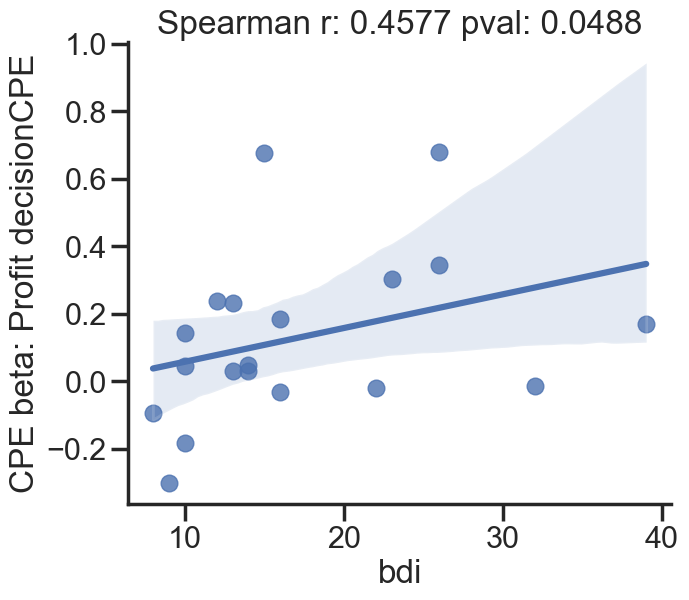

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


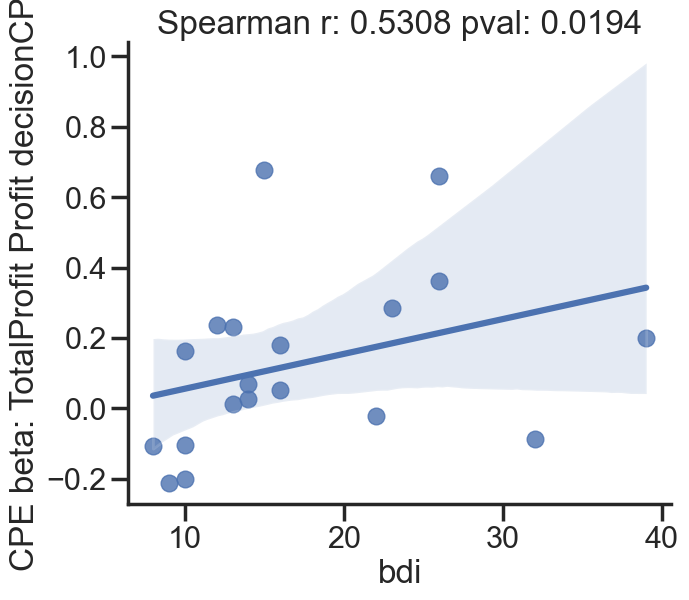

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


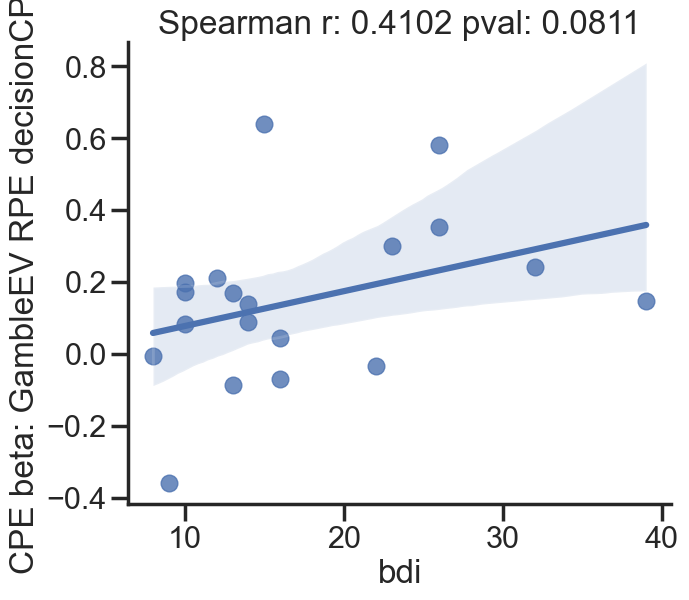

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


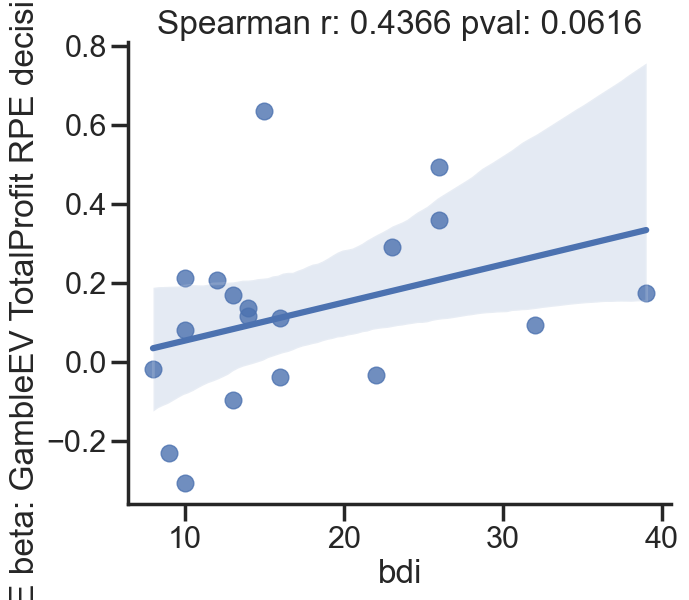

In [344]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

for model_id in trend_ids:
    model_df = model_param_dfs[model_id]
    
    # r,p = pearsonr(model_df.bdi,model_df.decisionCPE)
    r,p = spearmanr(model_df.bdi,model_df.decisionCPE)
    # t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20],equal_var=False)
    # print(t,p_t)
    # fig = plt.scatter(model_df.bdi,model_df.decisionCPE)

    fig,ax = plt.subplots(figsize=(7,6))
    sns.regplot(data=model_df,x='bdi',y='decisionCPE',scatter=True)
    vars4title = model_df.model_id.unique()[0].split('_')
    plt.ylabel(f'CPE beta: {(" ").join(vars4title)}')
    plt.title(f'Spearman r: {np.round(r,4)} pval: {np.round(p,4)}')
    sns.despine()
    plt.show()



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


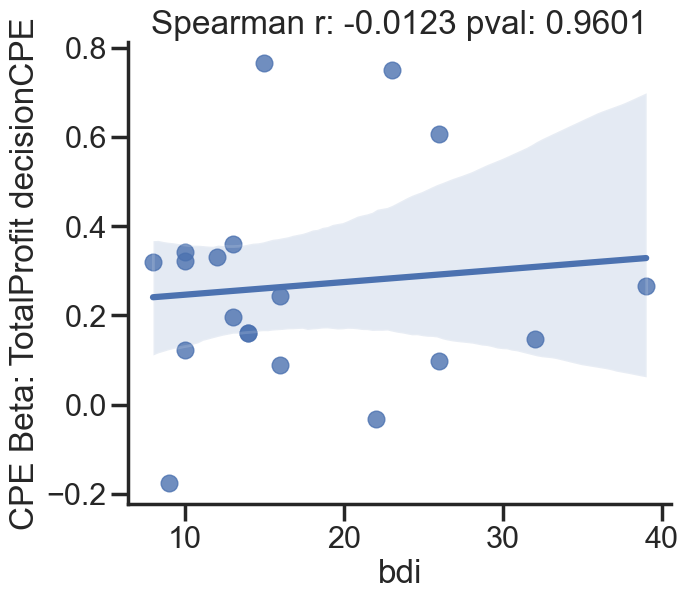

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


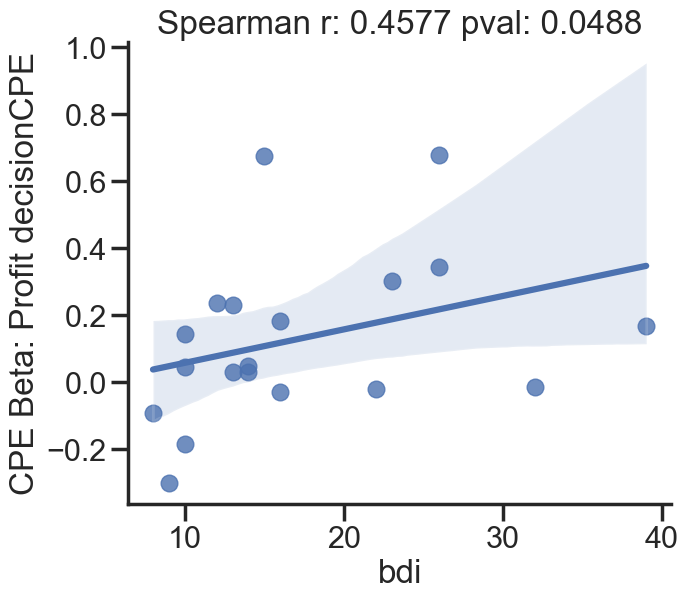

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


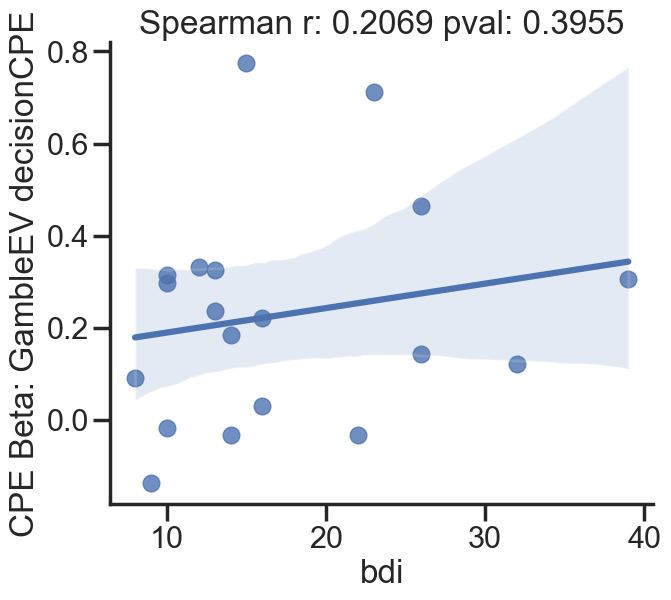

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


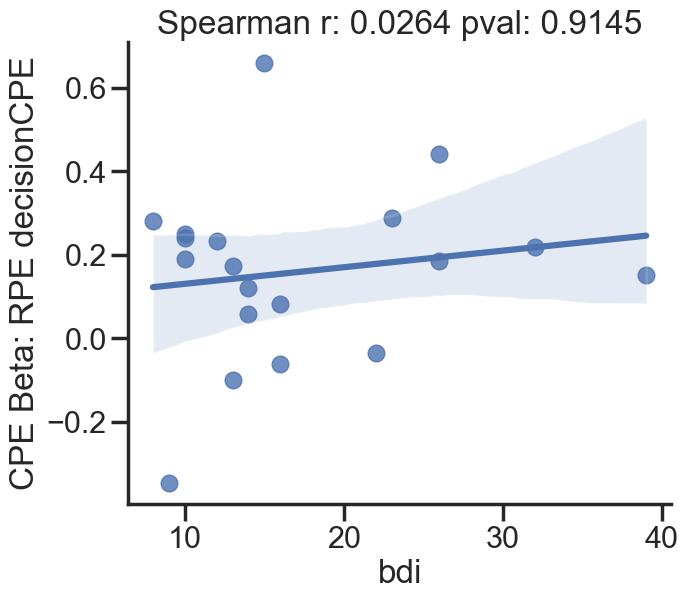

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


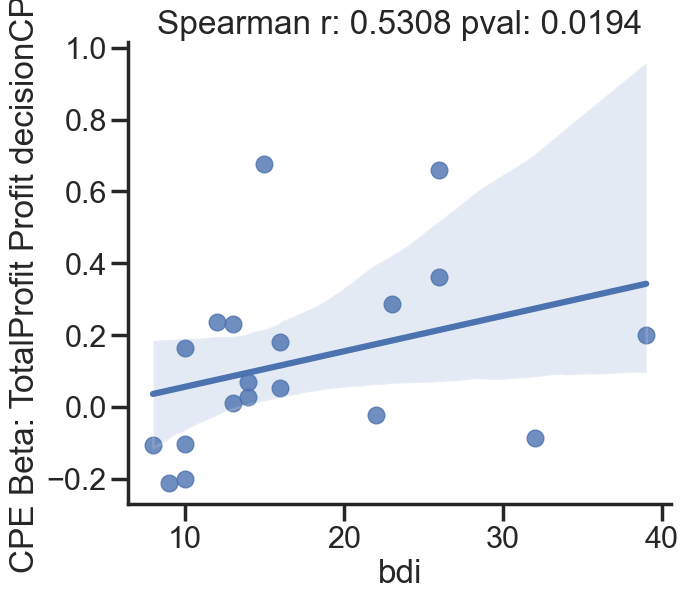

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


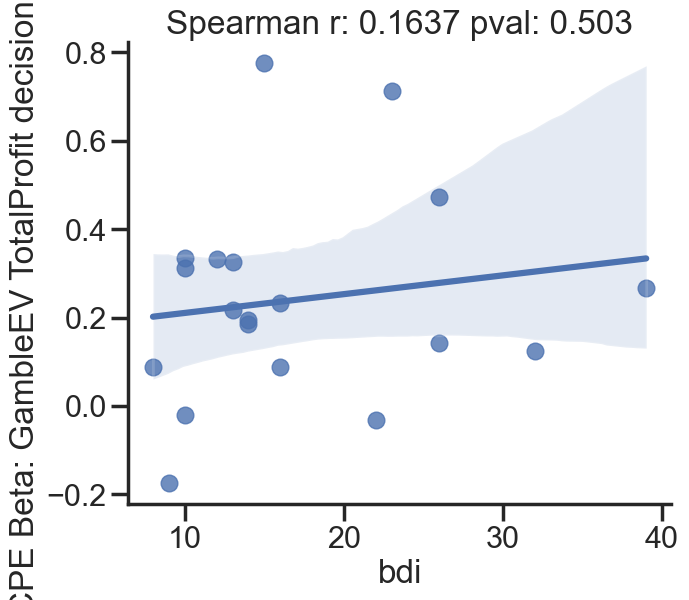

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


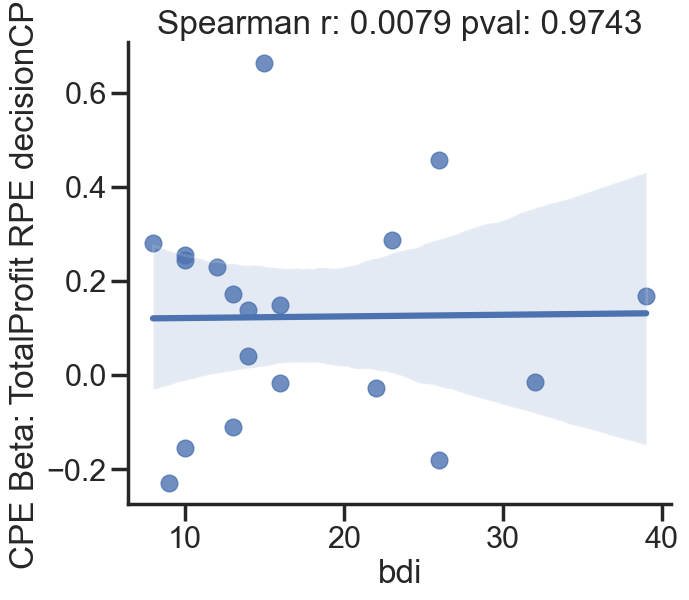

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


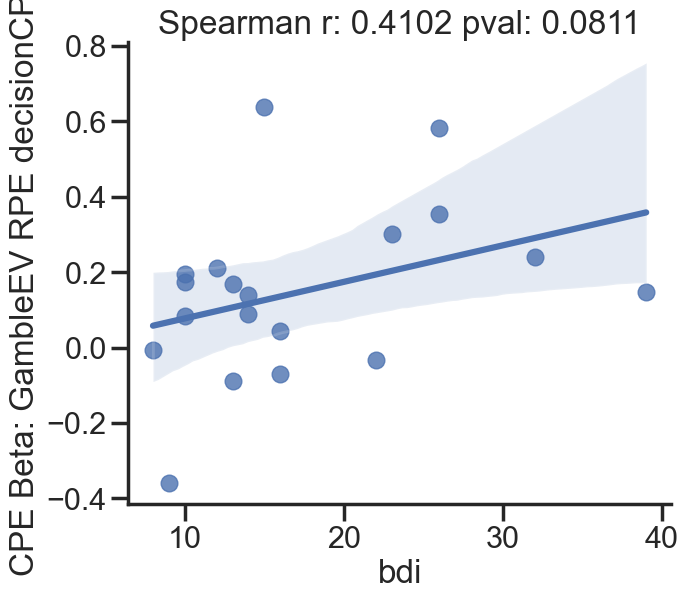

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


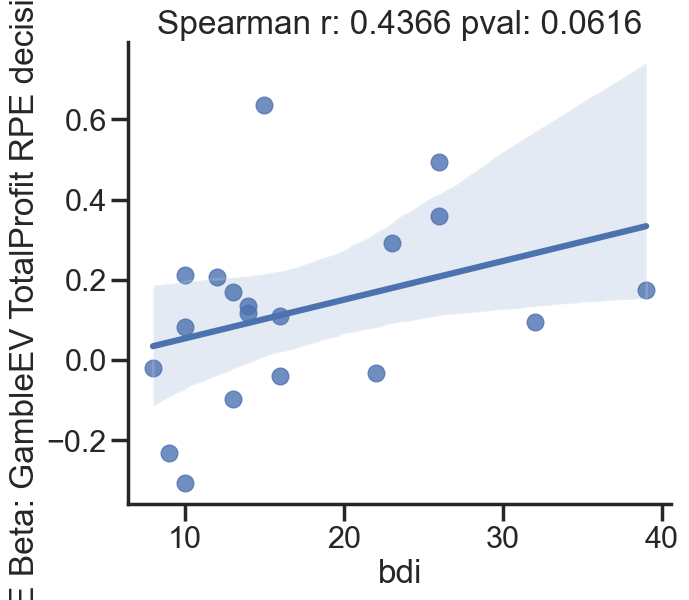

In [343]:
sig_models = []
for key in model_param_dfs.keys():
    model_df = model_param_dfs[key]
    
    r,p = spearmanr(model_df.bdi,model_df.decisionCPE)
    if p < 0.05:
        sig_models.append(model_df.model_id.unique())
    # t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20],equal_var=False)
    # print(t,p_t)
    # print(model_df.model_id.unique(),r,p)
    # fig = plt.scatter(model_df.bdi,model_df.decisionCPE)
    fig,ax = plt.subplots(figsize=(7,6))
    sns.regplot(data=model_df,x='bdi',y='decisionCPE',scatter=True)
    vars4title = model_df.model_id.unique()[0].split('_')
    plt.ylabel(f'CPE Beta: {(" ").join(vars4title)}')
    plt.title(f'Spearman r: {np.round(r,4)} pval: {np.round(p,4)}')
    sns.despine()
    plt.show()



    # pearsonr()
    # model_df

In [345]:
sig_models

[array(['Profit_decisionCPE'], dtype=object),
 array(['TotalProfit_Profit_decisionCPE'], dtype=object)]

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

for model_id in trend_ids:
    model_df = model_param_dfs[model_id]
    
    # r,p = pearsonr(model_df.bdi,model_df.decisionCPE)
    r,p = spearmanr(model_df.bdi,model_df.decisionCPE)
    # t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20],equal_var=False)
    # print(t,p_t)
    # fig = plt.scatter(model_df.bdi,model_df.decisionCPE)

    fig,ax = plt.subplots(figsize=(7,6))
    sns.regplot(data=model_df,x='bdi',y='decisionCPE',scatter=True)
    vars4title = model_df.model_id.unique()[0].split('_')
    plt.ylabel(f'CPE beta: {(" ").join(vars4title)}')
    plt.title(f'Spearman r: {np.round(r,4)} pval: {np.round(p,4)}')
    sns.despine()
    plt.show()

In [438]:
model_df = model_param_dfs['GambleEV_TotalProfit_RPE_decisionCPE']
    
# r,p = pearsonr(model_df.bdi,model_df.decisionCPE)
r,p = spearmanr(model_df.bdi,model_df.decisionCPE)
print(r,p)
# t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20],equal_var=False)
# print(t,p_t)
# fig = plt.scatter(model_df.bdi,model_df.decisionCPE)

# fig,ax = plt.subplots(figsize=(7,6))
# sns.regplot(data=model_df,x='bdi',y='decisionCPE',scatter=True)
# vars4title = model_df.model_id.unique()[0].split('_')
# plt.ylabel(f'CPE beta: {(" ").join(vars4title)}')
# plt.title(f'Spearman r: {np.round(r,4)} pval: {np.round(p,4)}')
# sns.despine()
# plt.show()

0.43662242501350407Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 0.0616146723164272


In [442]:
spearmanr(model_df.bdi,model_df.GambleEV)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=-0.3494739974402442, pvalue=0.14248024194593242)

In [439]:
spearmanr(model_df.bdi,model_df.RPE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=-0.24912126265891463, pvalue=0.3037121828014538)

In [440]:
spearmanr(model_df.bdi,model_df.TotalProfit)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=-0.14260651784715256, pvalue=0.560299396113592)

In [441]:
spearmanr(model_df.bdi,model_df.decisionCPE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=0.43662242501350407, pvalue=0.0616146723164272)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


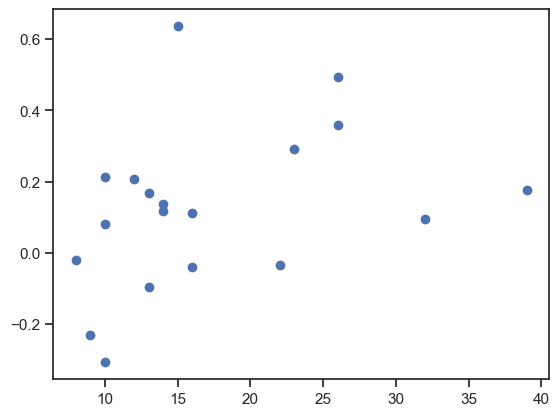

In [444]:
spearmanr(model_df.bdi,model_df.decisionCPE)
plt.scatter(model_df.bdi,model_df.decisionCPE)

In [432]:
depression_weights_plot = model_param_dfs['Profit_decisionCPE']
depression_weights_plot['Depression'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in depression_weights_plot.bdi]
depression_weights_plot

,subj_id,gamma,beta0,Profit,decisionCPE,model_id,bdi,Depressed,Depression
0,MS002,0.707308,0.011450,0.415805,0.029595,Profit_decisionCPE,14,Low BDI,Low BDI
1,MS003,1.000000,0.008513,0.260363,-0.093002,Profit_decisionCPE,8,Low BDI,Low BDI
2,MS009,0.625049,0.001101,0.135169,-0.030077,Profit_decisionCPE,16,Low BDI,Low BDI
3,MS011,0.373966,0.005489,0.299782,0.030056,Profit_decisionCPE,13,Low BDI,Low BDI
4,MS015,0.261065,0.044589,-0.525378,0.677623,Profit_decisionCPE,26,High BDI,High BDI
5,MS017,0.642986,-0.056907,0.232361,0.345805,Profit_decisionCPE,26,High BDI,High BDI
6,MS019,0.284728,0.031525,0.086356,0.238114,Profit_decisionCPE,12,Low BDI,Low BDI
7,MS022,0.125148,-0.012254,0.338774,0.045048,Profit_decisionCPE,10,Low BDI,Low BDI
8,MS024,0.122046,-0.018418,0.266676,0.183912,Profit_decisionCPE,16,Low BDI,Low BDI
9,MS025,0.845673,0.062440,0.783765,0.143634,Profit_decisionCPE,10,Low BDI,Low BDI


In [433]:
spearmanr(depression_weights_plot.bdi,depression_weights_plot.decisionCPE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=0.4577493165464156, pvalue=0.048754896591230175)

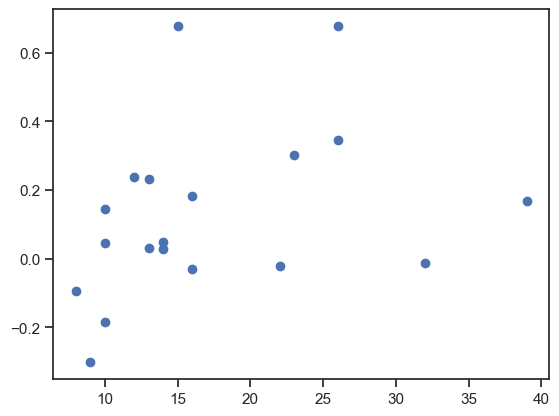

In [436]:
plt.scatter(depression_weights_plot.bdi,depression_weights_plot.decisionCPE)

In [356]:
t,p_t = ttest_ind(depression_weights_plot.decisionCPE[depression_weights_plot.bdi<20],depression_weights_plot.decisionCPE[depression_weights_plot.bdi>=20])
print(t,p_t)

-1.3616784147240402 0.19107372178228554


Text(0.5, 1.0, 'CPE')

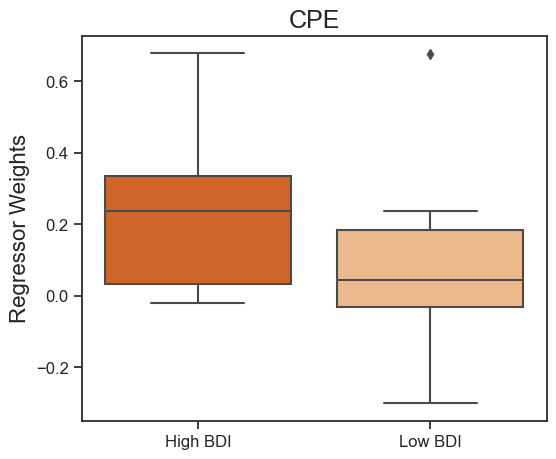

In [352]:
fig,ax1 = plt.subplots(1,1,figsize=(6,5))
sns.set_theme(style='ticks',font='Arial') 
sns.boxplot(ax=ax1,data=depression_weights_plot, x='Depression',y='decisionCPE',order=["High BDI", "Low BDI"],palette='Oranges_r')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('CPE',weight='medium',fontsize=18)

#fig.supylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
#fig.suptitle('Altered Emotional Sensitivity to \n Reward Signals in Depression',y=0.93,weight='semibold',fontsize=20)


In [430]:
depression_weights_plot2 = model_param_dfs['TotalProfit_Profit_decisionCPE']
depression_weights_plot2['Depression'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in depression_weights_plot2.bdi]
depression_weights_plot2

,subj_id,gamma,beta0,TotalProfit,Profit,decisionCPE,model_id,bdi,Depression
0,MS002,0.653121,0.008253,0.180671,0.429058,0.027931,TotalProfit_Profit_decisionCPE,14,Low BDI
1,MS003,1.000000,-0.045411,-0.069679,0.273934,-0.105810,TotalProfit_Profit_decisionCPE,8,Low BDI
2,MS009,1.000000,-0.008352,-0.311721,0.061538,0.051972,TotalProfit_Profit_decisionCPE,16,Low BDI
3,MS011,0.361318,0.011105,0.067141,0.300194,0.012109,TotalProfit_Profit_decisionCPE,13,Low BDI
4,MS015,0.285809,-0.101966,-0.184731,-0.523127,0.660716,TotalProfit_Profit_decisionCPE,26,High BDI
5,MS017,0.633262,-0.022168,-0.020158,0.226642,0.360916,TotalProfit_Profit_decisionCPE,26,High BDI
6,MS019,0.283507,0.022395,0.006215,0.086893,0.237197,TotalProfit_Profit_decisionCPE,12,Low BDI
7,MS022,0.000100,-0.118992,0.758714,0.456952,-0.104153,TotalProfit_Profit_decisionCPE,10,Low BDI
8,MS024,0.161252,-0.292668,0.429004,0.220777,0.180487,TotalProfit_Profit_decisionCPE,16,Low BDI
9,MS025,0.762519,0.184268,0.293600,0.817772,0.163034,TotalProfit_Profit_decisionCPE,10,Low BDI


In [431]:
spearmanr(depression_weights_plot2.bdi,depression_weights_plot2.decisionCPE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=0.5308131497644012, pvalue=0.019369896623294313)

In [435]:
spearmanr(depression_weights_plot2.bdi,depression_weights_plot2.Profit)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=-0.3186639472880816, pvalue=0.18361545983915173)

In [358]:
t,p_t = ttest_ind(depression_weights_plot2.decisionCPE[depression_weights_plot2.bdi<20],depression_weights_plot2.decisionCPE[depression_weights_plot2.bdi>=20])
print(t,p_t)



-1.2702787540167473 0.2210964137650665


Text(0.5, 1.0, 'CPE')

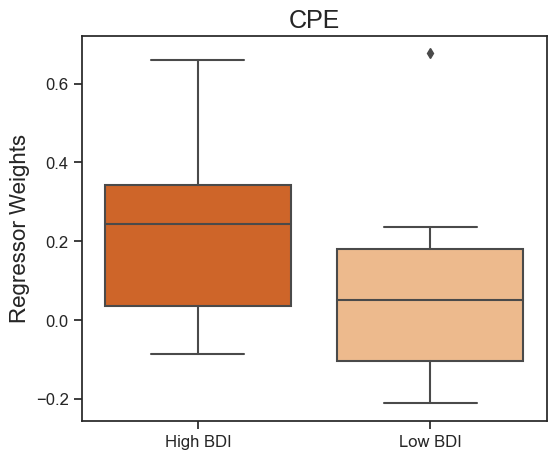

In [359]:
fig,ax1 = plt.subplots(1,1,figsize=(6,5))
sns.set_theme(style='ticks',font='Arial') 
sns.boxplot(ax=ax1,data=depression_weights_plot2, x='Depression',y='decisionCPE',order=["High BDI", "Low BDI"],palette='Oranges_r')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('CPE',weight='medium',fontsize=18)

In [360]:
depression_weights_plot

,subj_id,gamma,beta0,Profit,decisionCPE,model_id,bdi,Depressed,Depression
0,MS002,0.707308,0.011450,0.415805,0.029595,Profit_decisionCPE,14,Low BDI,Low BDI
1,MS003,1.000000,0.008513,0.260363,-0.093002,Profit_decisionCPE,8,Low BDI,Low BDI
2,MS009,0.625049,0.001101,0.135169,-0.030077,Profit_decisionCPE,16,Low BDI,Low BDI
3,MS011,0.373966,0.005489,0.299782,0.030056,Profit_decisionCPE,13,Low BDI,Low BDI
4,MS015,0.261065,0.044589,-0.525378,0.677623,Profit_decisionCPE,26,High BDI,High BDI
5,MS017,0.642986,-0.056907,0.232361,0.345805,Profit_decisionCPE,26,High BDI,High BDI
6,MS019,0.284728,0.031525,0.086356,0.238114,Profit_decisionCPE,12,Low BDI,Low BDI
7,MS022,0.125148,-0.012254,0.338774,0.045048,Profit_decisionCPE,10,Low BDI,Low BDI
8,MS024,0.122046,-0.018418,0.266676,0.183912,Profit_decisionCPE,16,Low BDI,Low BDI
9,MS025,0.845673,0.062440,0.783765,0.143634,Profit_decisionCPE,10,Low BDI,Low BDI


Text(0.5, 1.0, 'CPE')

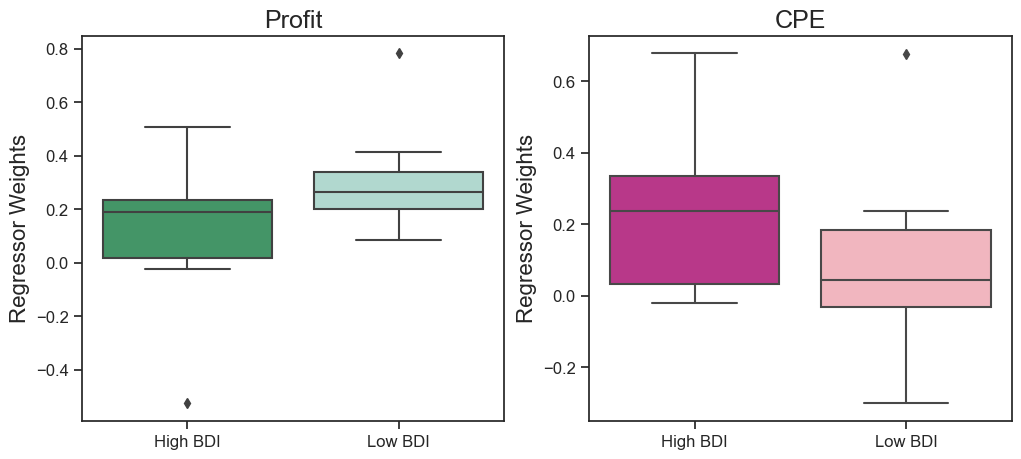

In [366]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
sns.set_theme(style='ticks',font='Arial') 
sns.boxplot(ax=ax1,data=depression_weights_plot, x='Depression',y='Profit',order=["High BDI", "Low BDI"],palette='BuGn_r')
sns.boxplot(ax=ax2,data=depression_weights_plot, x='Depression',y='decisionCPE',order=["High BDI", "Low BDI"],palette='RdPu_r')


#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Profit',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax2.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('CPE',weight='medium',fontsize=18)




In [367]:
model_param_dfs.keys()

dict_keys(['TotalProfit_decisionCPE', 'Profit_decisionCPE', 'GambleEV_decisionCPE', 'RPE_decisionCPE', 'TotalProfit_Profit_decisionCPE', 'GambleEV_TotalProfit_decisionCPE', 'TotalProfit_RPE_decisionCPE', 'GambleEV_RPE_decisionCPE', 'GambleEV_TotalProfit_RPE_decisionCPE'])

In [368]:
depression_weights_plot3 = model_param_dfs['GambleEV_TotalProfit_RPE_decisionCPE']
depression_weights_plot3['Depression'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in depression_weights_plot3.bdi]
depression_weights_plot3

,subj_id,gamma,beta0,GambleEV,TotalProfit,RPE,decisionCPE,model_id,bdi,Depression
0,MS002,0.822206,0.000991,0.304619,0.112222,0.177962,0.135862,GambleEV_TotalProfit_RPE_decisionCPE,14,Low BDI
1,MS003,1.000000,-0.047094,0.218286,-0.084470,0.128944,-0.019066,GambleEV_TotalProfit_RPE_decisionCPE,8,Low BDI
2,MS009,0.000100,-0.003776,-0.112677,-0.954562,0.274094,-0.038771,GambleEV_TotalProfit_RPE_decisionCPE,16,Low BDI
3,MS011,0.606703,0.007573,0.075562,0.048063,0.379585,-0.097151,GambleEV_TotalProfit_RPE_decisionCPE,13,Low BDI
4,MS015,0.285612,-0.062738,-0.360608,-0.178382,-0.250511,0.493083,GambleEV_TotalProfit_RPE_decisionCPE,26,High BDI
5,MS017,0.671697,-0.020550,0.155577,-0.007984,0.142061,0.360014,GambleEV_TotalProfit_RPE_decisionCPE,26,High BDI
6,MS019,0.309180,0.013551,0.020161,0.015193,0.098845,0.207152,GambleEV_TotalProfit_RPE_decisionCPE,12,Low BDI
7,MS022,0.000100,-0.091921,0.252135,0.849148,0.527146,-0.306499,GambleEV_TotalProfit_RPE_decisionCPE,10,Low BDI
8,MS024,0.265188,-0.210698,-0.096194,0.358637,0.342316,0.110491,GambleEV_TotalProfit_RPE_decisionCPE,16,Low BDI
9,MS025,0.804682,0.091534,0.387313,0.207070,0.434615,0.211702,GambleEV_TotalProfit_RPE_decisionCPE,10,Low BDI


In [374]:
spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.decisionCPE)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SignificanceResult(statistic=0.43662242501350407, pvalue=0.0616146723164272)

In [384]:
_,p= spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.decisionCPE)
print(p)


0.0616146723164272Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'CPE Spearman R:0.437 P:0.062')

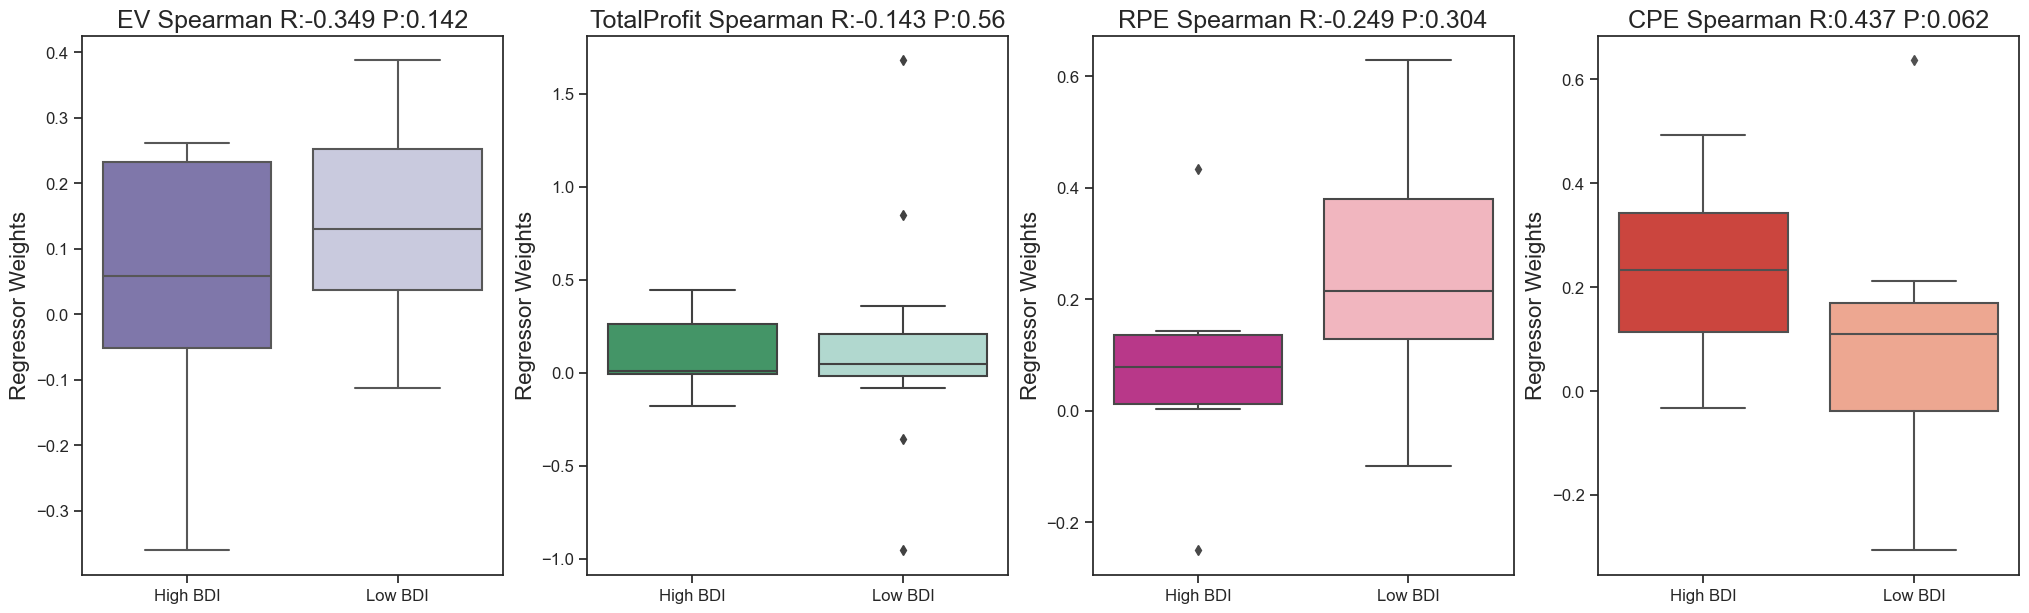

In [419]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25,7))
sns.set_theme(style='ticks',font='Arial') 
sns.boxplot(ax=ax1,data=depression_weights_plot3, x='Depression',y='GambleEV',order=["High BDI", "Low BDI"],palette='Purples_r')
sns.boxplot(ax=ax2,data=depression_weights_plot3, x='Depression',y='TotalProfit',order=["High BDI", "Low BDI"],palette='BuGn_r')
sns.boxplot(ax=ax3,data=depression_weights_plot3, x='Depression',y='RPE',order=["High BDI", "Low BDI"],palette='RdPu_r')
sns.boxplot(ax=ax4,data=depression_weights_plot3, x='Depression',y='decisionCPE',order=["High BDI", "Low BDI"],palette='Reds_r')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
r1,p1= spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.GambleEV)
ax1.set_title(f'EV Spearman R:{np.round(r1,3)} P:{np.round(p1,3)}',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax2.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
r2,p2= spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.TotalProfit)
ax2.set_title( f'TotalProfit Spearman R:{np.round(r2,3)} P:{np.round(p2,3)}',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax3.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
r3,p3= spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.RPE)
ax3.set_title(f'RPE Spearman R:{np.round(r3,3)} P:{np.round(p3,3)}',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax4.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax4.set_xlabel(None)
ax4.tick_params(labelsize=12)
r4,p4= spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.decisionCPE)
ax4.set_title(f'CPE Spearman R:{np.round(r4,3)} P:{np.round(p4,3)}',weight='medium',fontsize=18)



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


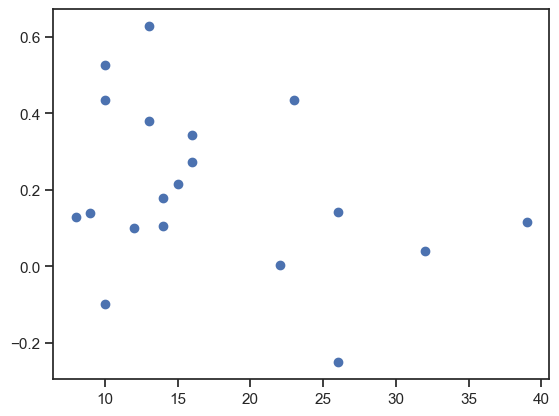

In [426]:
spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.RPE)
plt.scatter(depression_weights_plot3.bdi,depression_weights_plot3.RPE)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


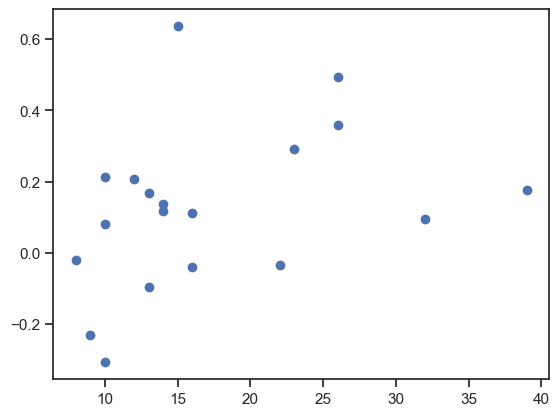

In [429]:
spearmanr(depression_weights_plot3.bdi,depression_weights_plot3.decisionCPE)
plt.scatter(depression_weights_plot3.bdi,depression_weights_plot3.decisionCPE)